<a href="https://colab.research.google.com/github/Nehasatheesh04/Holistic_Essay_Scoring/blob/main/BERT_ASAG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

# Load the dataset
file_path = "asag_dataset.csv"
df = pd.read_csv(file_path)

# Display basic information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 646 entries, 0 to 645
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Unnamed: 0           646 non-null    int64  
 1   question             646 non-null    object 
 2   student_answer       607 non-null    object 
 3   grades_round         646 non-null    int64  
 4   student_modified     606 non-null    object 
 5   ref_answer           646 non-null    object 
 6   qn_modified          646 non-null    object 
 7   ref_modified         646 non-null    object 
 8   student_demoted      606 non-null    object 
 9   ref_demoted          646 non-null    object 
 10  length_ratio         646 non-null    float64
 11  embed_ref            646 non-null    object 
 12  embed_stud           646 non-null    object 
 13  embed_ref_demoted    646 non-null    object 
 14  embed_stud_demoted   646 non-null    object 
 15  aligned              646 non-null    obj

In [ ]:
# df.head()
print(df.describe())
# Check for missing values
missing_values = df.isnull().sum()
print("Missing values in each column:\n", missing_values)



       Unnamed: 0  grades_round  length_ratio  cos_similarity  \
count  646.000000    646.000000    646.000000      646.000000   
mean   322.500000      1.369969      0.252263        0.733258   
std    186.628419      0.724518      0.148225        0.212926   
min      0.000000      0.000000      0.000000        0.000000   
25%    161.250000      1.000000      0.161837        0.709271   
50%    322.500000      2.000000      0.233747        0.790438   
75%    483.750000      2.000000      0.327405        0.849242   
max    645.000000      2.000000      1.000000        1.000000   

       cos_similarity_demo  aligned_score  aligned_score_demo  question_id  
count           646.000000     646.000000          646.000000   646.000000  
mean              0.693964       0.364100            0.319602     9.000000  
std               0.210168       0.180216            0.175425     4.902776  
min               0.000000       0.000000            0.000000     1.000000  
25%               0.655392   

In [ ]:
# # Print rows with missing values for each column
# for column in missing_values[missing_values > 0].index:
#     print(f"Rows with missing values in column '{column}':")
#     print(df[df[column].isnull()])
#     print("\n")

In [ ]:
# Check for rows where 'student_modified' or 'student_demoted' are missing but 'student_answer' is not
discrepancy_rows = df[df['student_answer'].notnull() & (df['student_modified'].isnull() | df['student_demoted'].isnull())]
print("Rows where 'student_answer' is present but 'student_modified' or 'student_demoted' are missing:")
print(discrepancy_rows)

Rows where 'student_answer' is present but 'student_modified' or 'student_demoted' are missing:
     Unnamed: 0                                           question  \
555         555  What are three items to be learned for an RBF ...   

    student_answer  grades_round student_modified  \
555              -             0              NaN   

                                            ref_answer  \
555  Three items to be learned are centers, weights...   

                                           qn_modified  \
555  three item learned rbf network difference nns ...   

                                          ref_modified student_demoted  \
555  three item learned center weight bias rbfn con...             NaN   

                                           ref_demoted  ...  embed_stud  \
555  center weight bias rbfn consists single hidden...  ...         0.0   

                                     embed_ref_demoted embed_stud_demoted  \
555  [[ 0.61642578 -0.19705078  0.61673096  1

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Fine-Tune BERT for ASAG

#### Improved BERT

Epoch 1/10 | Loss: 0.5804
Epoch 2/10 | Loss: 0.2945
Epoch 3/10 | Loss: 0.2324
Epoch 4/10 | Loss: 0.1836
Epoch 5/10 | Loss: 0.1345
Epoch 6/10 | Loss: 0.0832
Epoch 7/10 | Loss: 0.0680
Epoch 8/10 | Loss: 0.0442
Epoch 9/10 | Loss: 0.0358
Epoch 10/10 | Loss: 0.0267

📊 Final Evaluation Metrics:
Mean Squared Error (MSE): 0.189
Mean Absolute Error (MAE): 0.300
R² Score: 0.581


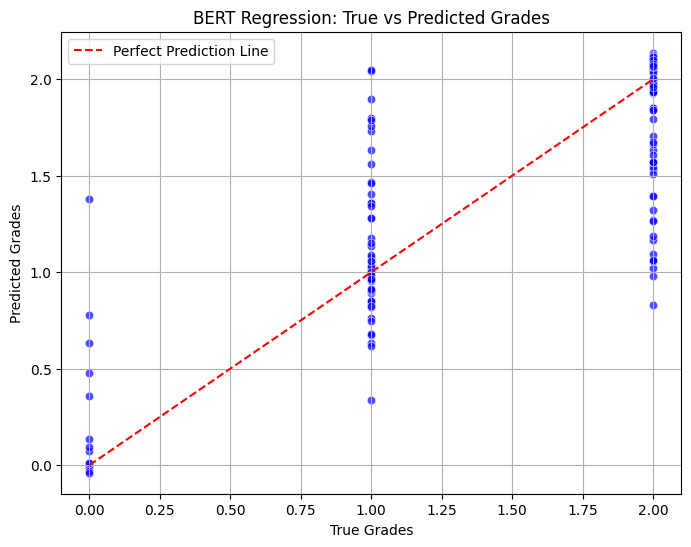


🔍 Example Predictions:

Reference Answer:
convolutional neural network consists of many layers such as a convolutional layer that has kernels which convolve over the input image, an activation layer ( relu activation ), pooling layer ( max or
Student Answer:
average pooling ), and one or more fully connected layers followed by softmax layer. cnn is has multiple layers and they dont use multiplication matrix.
True Grade: 0.00
Predicted Grade: 0.36

Reference Answer:
mathematical model of a neuron consists of a set of synapses or connecting links where each link is characterized by a weight, an adder function ( linear combiner ), which computes the weighted sum ( local field ) of the inputs
Student Answer:
plus some bias and an activation function ( squashing function ) for limiting the amplitude of a neuron ’ s output. a neuron consist of input connection links with a synaptic weight, a bias, an adder which adds the input singnals and the bias and produces the local field. the local fi

In [ ]:
# Install Hugging Face Transformers if not already installed
# !pip install transformers

import torch
import torch.nn as nn
from transformers import BertTokenizer, BertModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load dataset
df = pd.read_csv("/content/drive/MyDrive/asag_dataset.csv")

# 2. Tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# 3. Tokenization function
def tokenize_data(ref_texts, stud_texts, tokenizer, max_len=256):
    return tokenizer(
        list(ref_texts),
        list(stud_texts),
        padding='max_length',
        truncation="only_second",
        max_length=max_len,
        return_tensors="pt"
    )

# 4. Tokenize answers
tokenized = tokenize_data(df['ref_answer'].astype(str), df['student_answer'].astype(str), tokenizer)
input_ids = tokenized['input_ids']
attention_mask = tokenized['attention_mask']

# 5. Labels
y = torch.tensor(df['grades_round'].values, dtype=torch.float32)

# 6. Train-test split
X_train_ids, X_test_ids, y_train, y_test, mask_train, mask_test = train_test_split(
    input_ids, y, attention_mask, test_size=0.2, random_state=42
)

# 7. Create TensorDatasets
train_dataset = TensorDataset(X_train_ids, mask_train, y_train)
test_dataset = TensorDataset(X_test_ids, mask_test, y_test)

# 8. DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# 9. Regression Model with BERT
class BertRegressionModel(nn.Module):
    def __init__(self):
        super(BertRegressionModel, self).__init__()
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        self.dropout = nn.Dropout(p=0.3)
        self.regressor = nn.Linear(self.bert.config.hidden_size, 1)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        return self.regressor(pooled_output)

# 10. Initialize model and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BertRegressionModel().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

# 11. Training loop
def train_model(model, train_loader, criterion, optimizer, epochs=10):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for input_ids, attention_mask, labels in train_loader:
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            predictions = model(input_ids, attention_mask).squeeze()
            loss = criterion(predictions, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{epochs} | Loss: {avg_loss:.4f}")

# 12. Evaluation function
def evaluate_model(model, test_loader):
    model.eval()
    predictions, actuals = [], []
    with torch.no_grad():
        for input_ids, attention_mask, labels in test_loader:
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.to(device)

            preds = model(input_ids, attention_mask).squeeze()
            predictions.extend(preds.cpu().numpy())
            actuals.extend(labels.cpu().numpy())

    return predictions, actuals

# 13. Train
train_model(model, train_loader, criterion, optimizer, epochs=10)

# 14. Evaluate
y_pred, y_true = evaluate_model(model, test_loader)

# 15. Metrics
mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print("\n📊 Final Evaluation Metrics:")
print(f"Mean Squared Error (MSE): {mse:.3f}")
print(f"Mean Absolute Error (MAE): {mae:.3f}")
print(f"R² Score: {r2:.3f}")

# 16. Visualization
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_true, y=y_pred, color="blue", alpha=0.7)
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='red', linestyle='--', label='Perfect Prediction Line')
plt.xlabel("True Grades")
plt.ylabel("Predicted Grades")
plt.title("BERT Regression: True vs Predicted Grades")
plt.legend()
plt.grid(True)
plt.show()

# 17. Example Grading on Few Samples
print("\n🔍 Example Predictions:")
sample_idx = np.random.choice(len(X_test_ids), 5, replace=False)
sample_inputs = X_test_ids[sample_idx].to(device)
sample_masks = mask_test[sample_idx].to(device)
sample_labels = y_test[sample_idx]

model.eval()
with torch.no_grad():
    sample_preds = model(sample_inputs, sample_masks).squeeze()

for i in range(len(sample_preds)):
    ref_text = tokenizer.decode(X_test_ids[sample_idx[i]][:50], skip_special_tokens=True)
    stud_text = tokenizer.decode(X_test_ids[sample_idx[i]][50:], skip_special_tokens=True)
    print(f"\nReference Answer:\n{ref_text}")
    print(f"Student Answer:\n{stud_text}")
    print(f"True Grade: {sample_labels[i].item():.2f}")
    print(f"Predicted Grade: {sample_preds[i].item():.2f}")


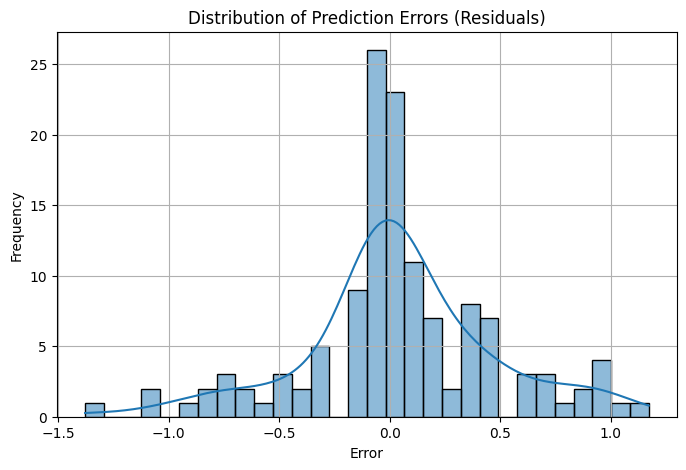

In [ ]:
errors = np.array(y_true) - np.array(y_pred)
plt.figure(figsize=(8,5))
sns.histplot(errors, bins=30, kde=True)
plt.title('Distribution of Prediction Errors (Residuals)')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.grid()
plt.show()

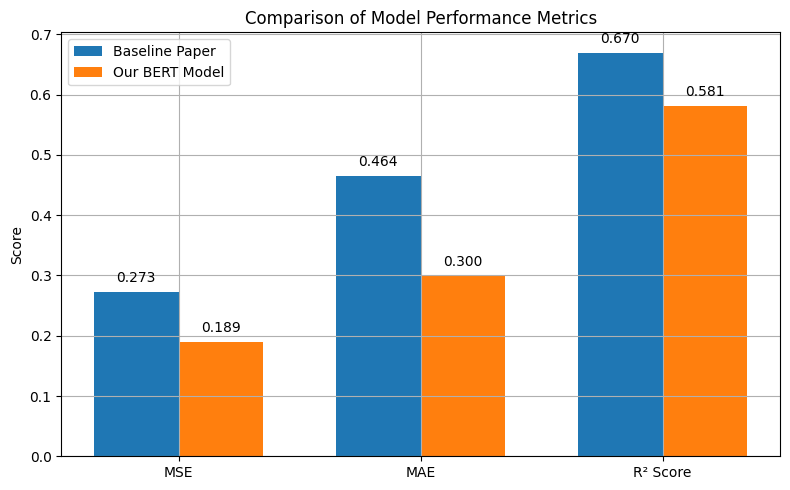

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Metrics
metrics = ['MSE', 'MAE', 'R² Score']
baseline = [0.2727, 0.4644, 0.67]
bert = [0.1890, 0.3000, 0.581]

# Bar positions
x = np.arange(len(metrics))
width = 0.35

# Create figure and bar plots
fig, ax = plt.subplots(figsize=(8, 5))
rects1 = ax.bar(x - width/2, baseline, width, label='Baseline Paper')
rects2 = ax.bar(x + width/2, bert, width, label='Our BERT Model')

# Labels and title
ax.set_ylabel('Score')
ax.set_title('Comparison of Model Performance Metrics')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# Annotate bars
for rects in [rects1, rects2]:
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 5),
                    textcoords="offset points",
                    ha='center', va='bottom')

plt.grid(True)
plt.tight_layout()
plt.show()
